In [1]:
import tensorflow as tf
from keras.datasets import cifar100
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import datetime, os

%load_ext tensorboard

In [2]:
#Load dataset
(X_c_train, y_c_train), (X_c_test, y_c_test) = cifar100.load_data(label_mode='coarse')
(X_f_train, y_f_train), (X_f_test, y_f_test) = cifar100.load_data(label_mode='fine')

X_train = X_f_train
X_val = X_f_test[:5000]
X_test = X_f_test[5000:]

y_train = [y_c_train, y_f_train]
y_val = [y_c_test[:5000], y_f_test[:5000]]
y_test = [y_c_test[5000:], y_f_test[5000:]]

image_size = X_train[0].shape

num_classes_c = len(set([v[0] for v in y_c_train]))
num_classes_f = len(set([v[0] for v in y_f_train]))



In [3]:
class global_accuracy(keras.callbacks.Callback):
    """
    Each `SquadExample` object contains the character level offsets for each token
    in its input paragraph. We use them to get back the span of text corresponding
    to the tokens between our predicted start and end tokens.
    All the ground-truth answers are also present in each `SquadExample` object.
    We calculate the percentage of data points where the span of text obtained
    from model predictions matches one of the ground-truth answers.
    """

    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval
        self.y_eval = y_eval

    def on_epoch_end(self, epoch, logs=None):
        pred_c, pred_f = self.model.predict(self.x_eval)
        accuracy = []
        accuracy_c = []
        accuracy_f = []
        for idx, (c, f) in enumerate(zip(pred_c, pred_f)):           
            c = np.argmax(c)
            f = np.argmax(f)
            if self.y_eval[0][idx][0] == c and self.y_eval[1][idx][0] == f:
              accuracy.append(1)
              accuracy_c.append(1)
              accuracy_f.append(1)
            elif self.y_eval[0][idx][0] == c and self.y_eval[1][idx][0] != f:
              accuracy.append(0)
              accuracy_c.append(1)
              accuracy_f.append(0)
            elif self.y_eval[0][idx][0] != c and self.y_eval[1][idx][0] == f:
              accuracy.append(0)
              accuracy_c.append(0)
              accuracy_f.append(1)
            else:
              accuracy.append(0)
              accuracy_c.append(0)
              accuracy_f.append(0)
        print('-'*100)
        print(f"epoch={epoch+1}, global accuracy = {np.mean(accuracy):.4f}±{(1.96 * np.std(accuracy)) / np.sqrt(len(accuracy)):.4f}, accuracy_c = {np.mean(accuracy_c):.4f}±{(1.96 * np.std(accuracy_c)) / np.sqrt(len(accuracy_c)):.4f}, accuracy_f = {np.mean(accuracy_f):.4f}±{(1.96 * np.std(accuracy_f)) / np.sqrt(len(accuracy_f)):.4f}")
        print('-'*100)
        print('')

Model: "Model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten (Flatten)               (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
out_c (Dense)                   (None, 20)           10260       flatten[0][0]                    
____________________________________________________________________________________________

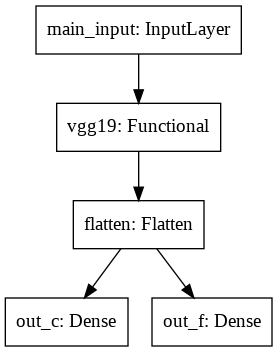

In [4]:
def get_model1(pi=0.5):
    # Conv base
    in_layer = Input(shape=image_size, name='main_input')
    conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")(in_layer)
    conv_base = Flatten()(conv_base)
    # coarse output
    out_c = Dense(num_classes_c, activation="softmax", name='out_c')(conv_base)
    # fine output 
    out_f = Dense(num_classes_f, activation="softmax", name='out_f')(conv_base)
    # Build the model
    model = Model(name='Model_1',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

model = get_model1()
model.summary()
plot_model(model)

Model: "Model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
out_c (Dense)                (None, 20)                10260     
_________________________________________________________________
out_f (Dense)                (None, 100)               2100      
Total params: 20,036,744
Trainable params: 20,036,744
Non-trainable params: 0
_________________________________________________________________


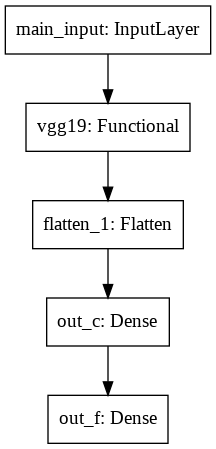

In [5]:
def get_model2(pi=0.5):
    # Conv base
    in_layer = Input(shape=image_size, name='main_input')
    conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")(in_layer)
    conv_base = Flatten()(conv_base)
    # coarse output
    out_c = Dense(num_classes_c, activation="softmax", name='out_c')(conv_base)
    # fine output 
    out_f = Dense(num_classes_f, activation="softmax", name='out_f')(out_c)
    # Build the model
    model = Model(name='Model_2',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

model = get_model2()
model.summary()
plot_model(model)

Model: "Model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
logits_c (Dense)                (None, 20)           10260       flatten_2[0][0]                  
____________________________________________________________________________________________

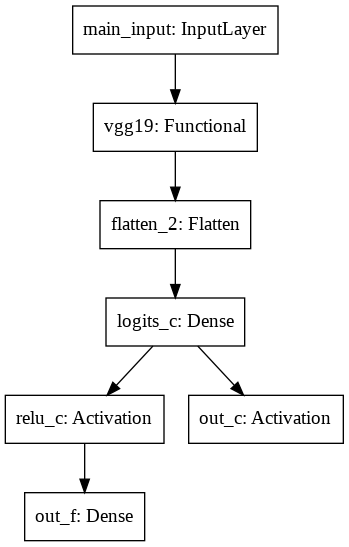

In [6]:
def get_model3(pi=0.5):
    # Conv base
    in_layer = Input(shape=image_size, name='main_input')
    conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")(in_layer)
    conv_base = Flatten()(conv_base)
    # coarse output
    logits_c = Dense(num_classes_c, name='logits_c')(conv_base)
    out_c = Activation(keras.activations.softmax, name='out_c')(logits_c)
    
    # fine output 
    relu_c = Activation(keras.activations.relu, name='relu_c')(logits_c)
    out_f = Dense(num_classes_f, activation="softmax", name='out_f')(relu_c)
    # Build the model
    model = Model(name='Model_3',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

model = get_model3()
model.summary()
plot_model(model)


Model: "Model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
logits_f (Dense)                (None, 100)          51300       flatten_3[0][0]                  
____________________________________________________________________________________________

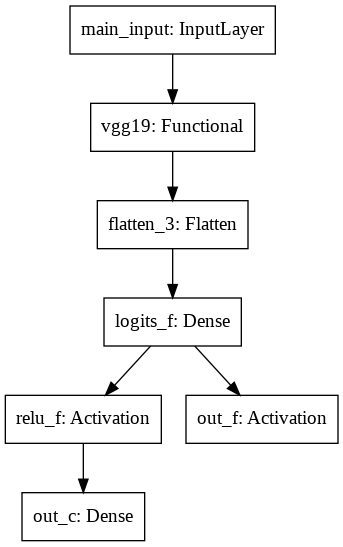

In [7]:
def get_model4(pi=0.5):
    # Conv base
    in_layer = Input(shape=image_size, name='main_input')
    conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")(in_layer)
    conv_base = Flatten()(conv_base)
    # coarse output
    logits_f = Dense(num_classes_f, name='logits_f')(conv_base)
    relu_f = Activation(keras.activations.relu, name='relu_f')(logits_f)
    out_c = Dense(num_classes_c, activation="softmax", name='out_c')(relu_f)
    # fine output 
    out_f = Activation(keras.activations.softmax, name='out_f')(logits_f)
    # Build the model
    model = Model(name='Model_4',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

model = get_model4()
model.summary()
plot_model(model)


Model: "Model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19_1 (Functional)            (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
vgg19_2 (Functional)            (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 512)          0           vgg19_1[0][0]                    
____________________________________________________________________________________________

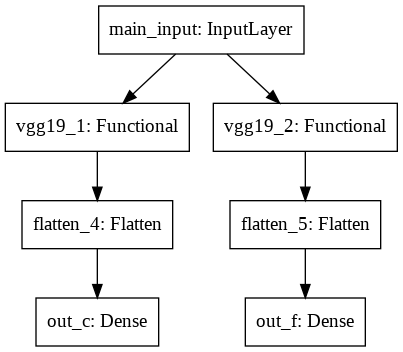

In [8]:
def get_model5(pi=0.5):
    # Conv base
    conv_base1 = keras.applications.VGG19(
    include_top=False,
    weights="imagenet")
    conv_base1._name = 'vgg19_1'
    conv_base2 = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")
    conv_base2._name = 'vgg19_2'
    in_layer = Input(shape=image_size, name='main_input')
    conv_base1 = conv_base1(in_layer)    
    conv_base1 = Flatten()(conv_base1)

    conv_base2 = conv_base2(in_layer)
    conv_base2 = Flatten()(conv_base2)
    # coarse output
    out_c = Dense(num_classes_c, activation="softmax", name='out_c')(conv_base1)
    # fine output 
    out_f = Dense(num_classes_f, activation="softmax", name='out_f')(conv_base2)
    # Build the model
    model = Model(name='Model_5',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

model = get_model5()
model.summary()
plot_model(model)

In [ ]:
# Create the model
model = get_model1(1)
model.summary()
plot_model(model)
#train model
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
global_accuracy_callback = global_accuracy(X_val, y_val)
batch = 128
history = model.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=20,
                    callbacks=[tensorboard_callback, global_accuracy_callback])

# model.evaluate(X_test, y_test)


Model: "Model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_96 (Flatten)            (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
out_c (Dense)                   (None, 20)           10260       flatten_96[0][0]                 
____________________________________________________________________________________________

In [ ]:
# Create the model
model = get_model1(0)
model.summary()
plot_model(model)
#train model
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
global_accuracy_callback = global_accuracy(X_val, y_val)
batch = 128
history = model.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=20,
                    callbacks=[tensorboard_callback, global_accuracy_callback])



Model: "Model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_98 (Flatten)            (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
out_c (Dense)                   (None, 20)           10260       flatten_98[0][0]                 
____________________________________________________________________________________________

In [ ]:
# Create the model
model = get_model1(0.5)
model.summary()
plot_model(model)
#train model
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
global_accuracy_callback = global_accuracy(X_val, y_val)
batch = 128
history = model.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=20,
                    callbacks=[tensorboard_callback, global_accuracy_callback])



Model: "Model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_99 (Flatten)            (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
out_c (Dense)                   (None, 20)           10260       flatten_99[0][0]                 
____________________________________________________________________________________________

In [ ]:
# Create the model
model = get_model2(0.5)
model.summary()
plot_model(model)
#train model
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
global_accuracy_callback = global_accuracy(X_val, y_val)
batch = 128
history = model.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=20,
                    callbacks=[tensorboard_callback, global_accuracy_callback])



Model: "Model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_100 (Flatten)        (None, 512)               0         
_________________________________________________________________
out_c (Dense)                (None, 20)                10260     
_________________________________________________________________
out_f (Dense)                (None, 100)               2100      
Total params: 20,036,744
Trainable params: 20,036,744
Non-trainable params: 0
_________________________________________________________________
ERROR:tensorflow:Failed to start profiler: Another profiler is running.
Epoch 1/20
391/391 [=====================

In [ ]:
# Create the model
model = get_model3(0.5)
model.summary()
plot_model(model)
#train model
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
global_accuracy_callback = global_accuracy(X_val, y_val)
batch = 128
history = model.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=20,
                    callbacks=[tensorboard_callback, global_accuracy_callback])



Model: "Model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_101 (Flatten)           (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
logits_c (Dense)                (None, 20)           10260       flatten_101[0][0]                
____________________________________________________________________________________________

In [9]:
# Create the model
model = get_model4(0.5)
model.summary()
plot_model(model)
#train model
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
global_accuracy_callback = global_accuracy(X_val, y_val)
batch = 128
history = model.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=20,
                    callbacks=[tensorboard_callback, global_accuracy_callback])



Model: "Model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
logits_f (Dense)                (None, 100)          51300       flatten_6[0][0]                  
____________________________________________________________________________________________

In [10]:
# Create the model
model = get_model5(0.5)
model.summary()
plot_model(model)
#train model
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
global_accuracy_callback = global_accuracy(X_val, y_val)
batch = 128
history = model.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=20,
                    callbacks=[tensorboard_callback, global_accuracy_callback])



Model: "Model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19_1 (Functional)            (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
vgg19_2 (Functional)            (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 512)          0           vgg19_1[0][0]                    
____________________________________________________________________________________________

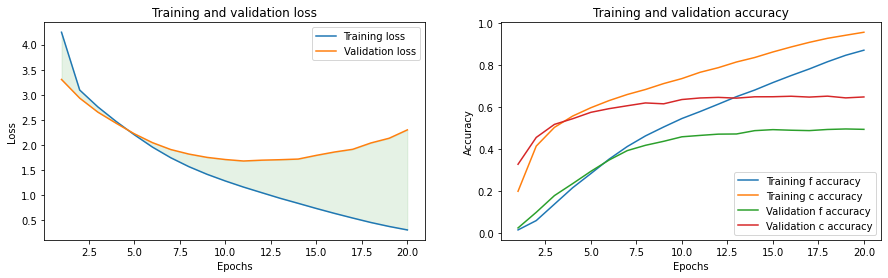

In [11]:
out_f_accuracy = history.history['out_f_accuracy']
out_c_accuracy = history.history['out_c_accuracy']
val_out_f_accuracy = history.history['val_out_f_accuracy']
val_out_c_accuracy = history.history['val_out_c_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(15,4))

ax1 = plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.fill_between(epochs, loss,val_loss,color='g',alpha=.1)

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

ax2 = plt.subplot(1, 2, 2)
plt.plot(epochs, out_f_accuracy, label='Training f accuracy')
plt.plot(epochs, out_c_accuracy, label='Training c accuracy')
plt.plot(epochs, val_out_f_accuracy, label='Validation f accuracy')
plt.plot(epochs, val_out_c_accuracy, label='Validation c accuracy')
# plt.fill_between(epochs, acc,val_acc,color='g',alpha=.1)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()